# Modeling of the Final Engineered Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    recall_score,
    precision_score,
    roc_auc_score,
    make_scorer, 
    roc_curve, 
    precision_recall_curve, 
    auc
)

plt.style.use('fivethirtyeight')

In [2]:
# importing clean train dataset that was saved earlier
train = pd.read_csv('../data/train_cleaned.csv')
test = pd.read_csv('../data/test_cleaned.csv')
weather = pd.read_csv('../data/weather_combined.csv')
train.drop(columns=['Unnamed: 0', 'nummosquitos'], inplace=True)
test.drop(columns='Unnamed: 0', inplace=True)
submission = pd.DataFrame(test['Id'])
submission = submission.astype(int)

In [3]:
train = pd.merge(train, weather, how='left', left_on='date', right_on='Date')
train.drop(columns=['date', 'Year', 'Month', 'Date'], inplace=True)

In [4]:
test = pd.merge(test, weather, how='left', left_on='date', right_on='Date')
test.drop(columns=['date', 'Year', 'Month', 'Date'], inplace=True)

In [5]:
target = 'wnvpresent'
features = [feature for feature in train.columns if feature != target]
X = train[features]
y = train[target]
y = y.astype(int)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [7]:
maxfeat = int(np.round(np.sqrt(X_test.shape[1])))
maxdepth = int(np.round(maxfeat / 3))

In [8]:
# Initiating models:
lr = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier()
rf = RandomForestClassifier()

In [9]:
# Initiating models with pipeline:
lr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', lr)
])

In [10]:
knn_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('knn', knn)
])

In [11]:
rf_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('rf', rf)
])

---

### Baseline

We can evaluate the model based on the following metrics:
- Accuracy = (TP + TN) / (TP + TN + FP + FN)
- Sensitivity = TP / (TP + FN)
- Specificity = TN / (TN + FP)
- Precision = TP / (TP + FP)
- AUC ROC

Accuracy should not be used in this imbalanced dataset, where only 5% of the observations actually has West Nile virus. Hence, a naive guess will most likely be 95% accurate, but the 5% wrong guess will be devastating.

AUC ROC is superior because it will give us a score across all False Positive rates that we choose and therefore it is more robust (rather than a specific False Positive rate score e.g. for a high recall).

We should achieve an AUC ROC score of more than the baseline of 0.5,  where the baseline occurs when the predictor makes random guesses which is half correct, half wrong.

---

Using Randomized Search:

- to tune model for best AUC ROC, we’ll set our winning model on this result.

In [12]:
scorer = roc_auc_score

In [13]:
### Randomized Search
# There are many hyper parameters that 
# could be tuned to increase its perfomance.

# Let's tune parametrs of the classifiers towards higher AUC ROC.

scoring = make_scorer(scorer)

lr_param_distributions = {
    'lr__penalty': ['l1', 'l2'],
    'lr__C': np.logspace(-5, 1, 100),
    'lr__class_weight': [None, 'balanced']
}

knn_param_distributions = {
    'knn__n_neighbors': list(range(1, 25)),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric':['euclidean','manhattan']
}

rf_param_distributions = {
    'rf__max_depth': list(range(2, maxdepth)),
    'rf__max_features': list(range(1, maxfeat)),
    'rf__min_samples_split': list(range(2, 9)),
    'rf__n_estimators': list(range(200, 501)),
    'rf__class_weight': [None, 'balanced', 'balanced_subsample']
}

In [14]:
# Optimize hyper parameters using randomized search according to one of the scores that is input
lr_rs = RandomizedSearchCV(
    lr_pipe, param_distributions=lr_param_distributions,
    scoring=scoring,
    n_jobs=-1,
    cv=5,
    verbose=1
)

knn_rs = RandomizedSearchCV(
    knn_pipe, param_distributions=knn_param_distributions,
    scoring=scoring,
    n_jobs=-1,
    cv=5,
    verbose=1
)

rf_rs = RandomizedSearchCV(
    rf_pipe, param_distributions=rf_param_distributions,
    scoring=scoring,
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [15]:
# Get metrics for 3 different models for one dataset
models = {'Logistic Regression': lr_rs,'K-Nearest Neighbors': knn_rs,'Random Forest': rf_rs}
ss = pd.DataFrame()
cols = []
for key, model in models.items():
    cols.append(key)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    accur = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    aucroc = roc_auc_score(y_test, y_score[:, 1])
    data = {
        'Accuracy': accur,
        'Recall': recall, 
        'Precision': prec,
        'ROC AUC': aucroc,
        'Model': model.best_estimator_ # Included to easily call the model via masking if required
    }
    col = pd.Series(data)
    df = pd.DataFrame(col)
    ss = pd.concat([ss, df], axis=1)
ss.columns = cols

# Print dataframe without model
metrics = [metric for metric in ss.index if metric != 'Model']
ss.loc[metrics, :]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   47.7s finished


,Logistic Regression,K-Nearest Neighbors,Random Forest
Accuracy,0.693567,0.934145,0.658927
Recall,0.746377,0.0724638,0.869565
Precision,0.117984,0.181818,0.12024
ROC AUC,0.776975,0.71458,0.825668


- For imbalanced dataset, LogisticRegression and RandomForest are likely to predict better, given they have the option to introduce weights to each class, i.e. a heavier weight to be given to data where the virus is present since it’s only about 5% of the whole dataset.
- K-Nearest Neighbors doesn’t have the option, hence its ROC AUC is lowest out of the 3.
- In this case, RandomForest is the best model and hence we will use this model for further analysis and interpretation.

---

## Let’s use the ‘winning’ model for further data analysis

In [16]:
# Automatically calls the model based on highest ROC AUC score
scores = ss.loc['ROC AUC', :]
win_model = scores[scores == scores.max()]
win_model = win_model.index
win_model = win_model.format()
win_model = win_model[0]
print('Winning Model: {}'.format(win_model))
model = ss.loc['Model', win_model]

Winning Model: Random Forest


In [17]:
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
precision, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])

roc_auc_score:  0.826
precision-recall_auc_score:  0.198


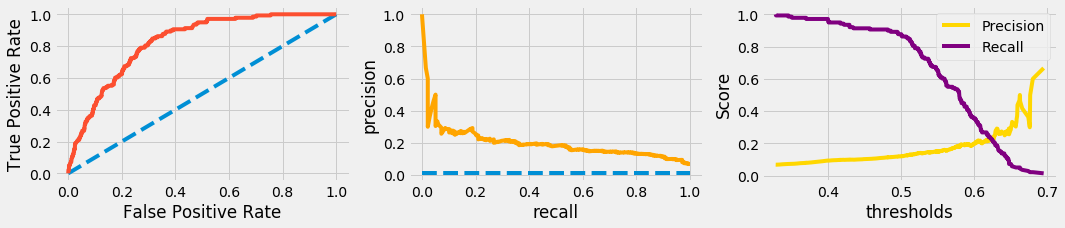

In [18]:
print("roc_auc_score: ", round(roc_auc_score(y_test, y_score[:, 1]), 3))
print("precision-recall_auc_score: ", round(auc(recall,precision), 3))
plt.subplots(figsize=(16, 3))
plt.subplot(1, 3, 1)
xx = np.linspace(0, 1, 1000)
yy = xx
plt.plot(xx, yy, '--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.subplot(1, 3, 2)
plt.plot([0, 1], [0.01, 0.01], '--')
plt.plot(recall, precision, color='orange')
plt.xlabel('recall')
plt.ylabel('precision')

plt.subplot(1, 3, 3)
plt.plot(thresholds, precision[:-1], 'gold', label="Precision")
plt.plot(thresholds, recall[:-1], 'purple', label='Recall')
plt.xlabel('thresholds')
plt.ylabel('Score')
plt.legend(loc='best');

TOP-LEFT:

- Since we are interested in high recall rather then precision, we can choose a relatively high FP rate to (around 0.5, after the peak)

TOP-RIGHT:

- Similarly threshold we can pick is 0.4 where recall is above 0.8 while precision is 0.2

## Feature importance:
- Out of so many features, let’s choose the ones with the strongest effect on WNV response
- We choose a threshold of 0.01 to display ( to avoid showing all features)

In [19]:
threshold = 0.01 

In [20]:
if win_model == 'Random Forest':
    most = model.named_steps['rf'].feature_importances_
if win_model == 'Logistic Regression':
    most = model.named_steps['lr'].coef_
    most = most[0]
    most = np.exp(most)

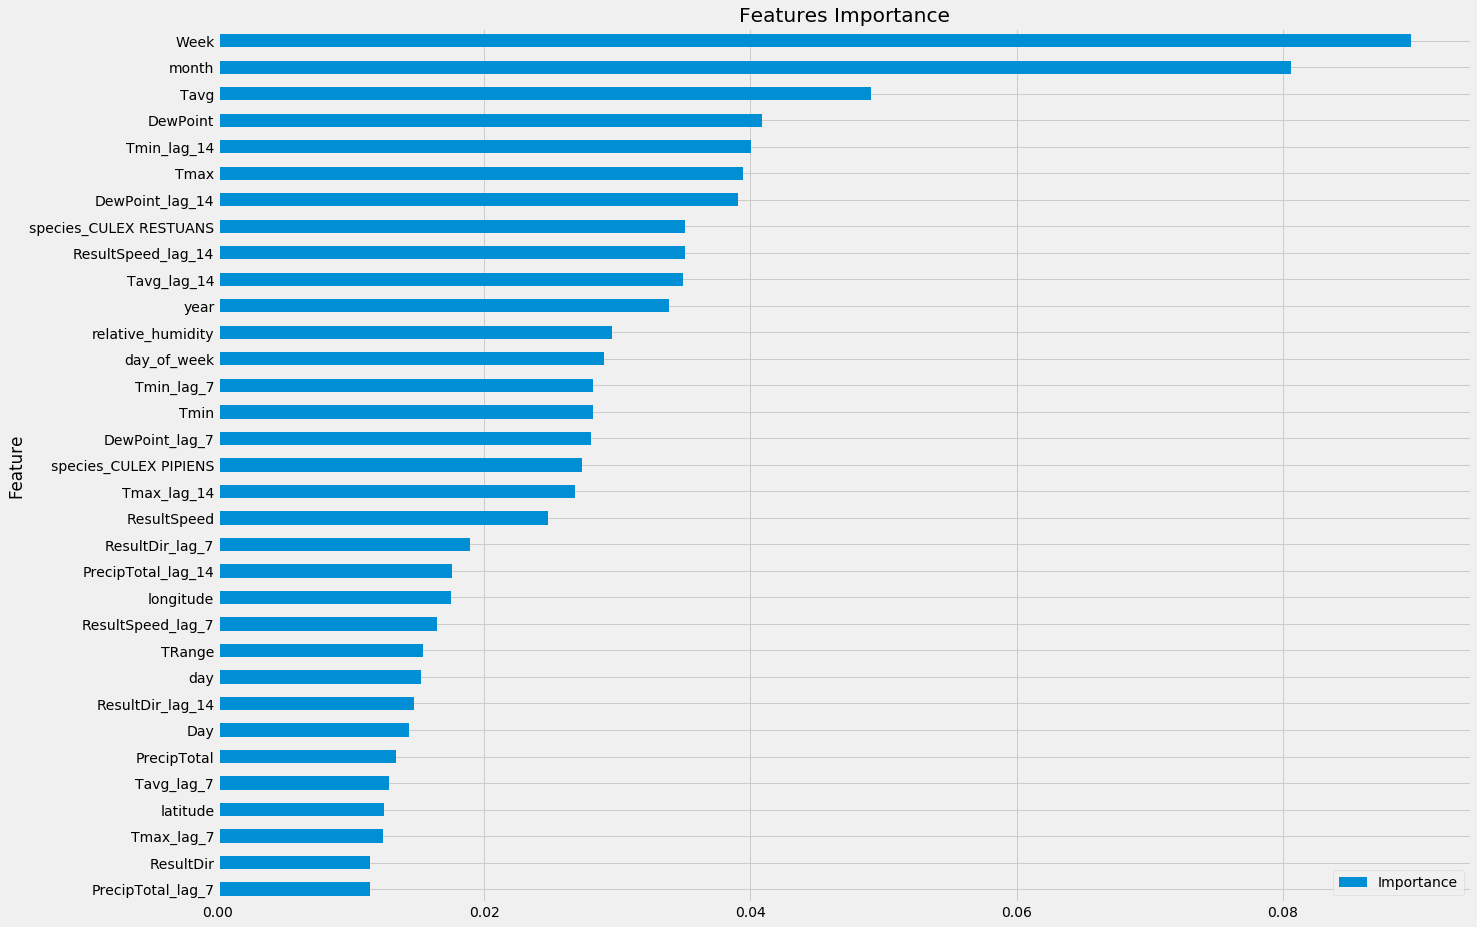

In [21]:
important_feature = pd.DataFrame({'Feature': X_train.columns, 'Importance': most})
important_feature = important_feature.sort_values('Importance', ascending=True)
important_feature = important_feature[important_feature['Importance'] > threshold]
important_feature.plot.barh('Feature', 'Importance', figsize=(20, 15))
plt.title('Features Importance');

## Feature importance discussion:
- Whether the specie is `CULEX_PIPIENS` or `CULEX RESTUANS` or not is important, as well as the week / month in the year (e.g. peak of summer) is also, unsurprisingly important
- Most important features are engineered weather features
- From weather data, temperature seems most important (probably affect breeding of mosquitoes)
- Wind speed possibly played a part (`ResultSpeed_lag_14`)
- Finally, some years have more occurrences then other years

## Discussion – Model Performance¶

- AUC under the ROC curve is ~83% so the model is robust enough to allow flexible choice of thresholds ( choosing the most fitting recall vs precision rates)
- The model is based on the assumption that the number of mosquitos is not a valid info that could be collected and used for prediction. The model’s performance would change if we include the `NumMosquitos` variable. At this scenario we can use all other features to predict the number of mosquitos, and then use that prediction as a new feature in a new classification model, to make a new prediction for the WNV occurrences. We can expect that the performance of this model would be higher given an additional feature which is highly correlated to whether virus is present.
- The data could be enriched further with publicly available data, e.g. Implementing data on locations of exposed water reservoirs, lakes and other bodies of fresh water which might be correlated to increased mosquito population.

## Kaggle Submission

In [22]:
submission['WnvPresent'] = model.predict(test[features])
submission.to_csv('../data/submission.csv', index=False)